In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/porcelain')
mask_dir = os.path.join(dataset_dir,'mask/porcelain')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/porcelain C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/porcelain
15759
15759


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-02-13 18:28:15,494: INFO: 3804955329: date_time: 20250213-182815]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "unet",
    "backbone" : "resnet34", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-13 18:28:15,634: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-13 18:28:15,634: INFO: 342151172: model_config: {'model_name': 'unet', 'backbone': 'resnet34', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-13 18:28:15,637: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-13 18:28:15,640: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

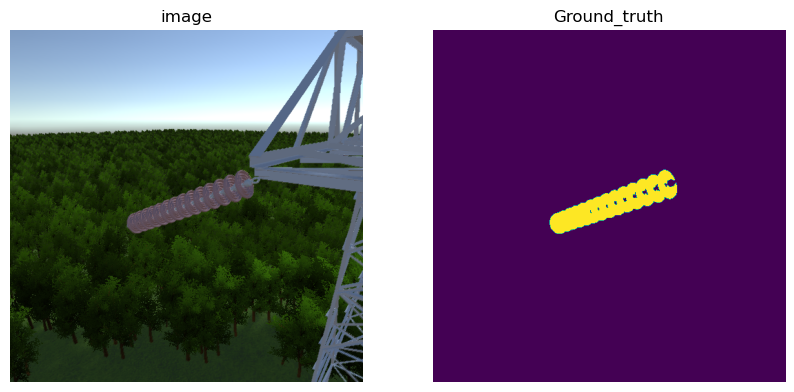

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-13 18:28:16,220: INFO: 3993860970: data injection started]
[2025-02-13 18:28:16,222: INFO: 3993860970: train data spliting ]
[2025-02-13 18:28:16,224: INFO: 3993860970: val test spliting ]
[2025-02-13 18:28:16,226: INFO: 3993860970: csv saving started]
[2025-02-13 18:28:16,265: INFO: 3993860970: train csv done ]
[2025-02-13 18:28:16,271: INFO: 3993860970: val csv done ]
[2025-02-13 18:28:16,278: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score_for_training.append(mean_miou_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [09:14<00:00,  3.79it/s, epoch=0, train_loss=0.0203, train_Miou_score=0.335, train_dice_score=0.721, train_acc=0.986, train_binary_jaccard_index=0.829]

[2025-02-13 18:38:56,279: INFO: 2245122998: Epoch: 0 | Training_Loss: 0.020330647532992085]
[2025-02-13 18:38:56,280: INFO: 2245122998: train_binary_jaccard_index: 0.8288799031902562]
[2025-02-13 18:38:56,281: INFO: 2245122998: train_loss 0.04884995287763832]
[2025-02-13 18:38:56,281: INFO: 2245122998: train_Miou_score 0.3345771313784068]
[2025-02-13 18:38:56,282: INFO: 2245122998: train_dice_score 0.721300859440235]
[2025-02-13 18:38:56,282: INFO: 2245122998: train_acc 0.985514565324012]



100%|██████████| 788/788 [01:11<00:00, 10.95it/s, epoch=0, eval_loss=0.0114, eval_Miou_score=0.339, eval_dice_score=0.773, eval_acc=0.989, eval_binary_jaccard_index=0.865]

[2025-02-13 18:40:08,246: INFO: 2245122998: Epoch: 0 | Loss: 0.011432501113959376]
[2025-02-13 18:40:08,246: INFO: 2245122998: eval_binary_jaccard_index: 0.8647766382844769]
[2025-02-13 18:40:08,247: INFO: 2245122998: eval_loss 0.012299988222207882]
[2025-02-13 18:40:08,247: INFO: 2245122998: eval_Miou_score 0.339437536507618]
[2025-02-13 18:40:08,248: INFO: 2245122998: eval_dice_score 0.7726202031484034]
[2025-02-13 18:40:08,248: INFO: 2245122998: eval_acc 0.988785591222308]



100%|██████████| 2102/2102 [06:00<00:00,  5.83it/s, epoch=1, train_loss=0.00775, train_Miou_score=0.348, train_dice_score=0.757, train_acc=0.989, train_binary_jaccard_index=0.865]

[2025-02-13 18:46:08,641: INFO: 2245122998: Epoch: 1 | Training_Loss: 0.0077510633489044365]
[2025-02-13 18:46:08,642: INFO: 2245122998: train_binary_jaccard_index: 0.8648187049108953]
[2025-02-13 18:46:08,643: INFO: 2245122998: train_loss 0.028460481579791138]
[2025-02-13 18:46:08,644: INFO: 2245122998: train_Miou_score 0.34767796610837376]
[2025-02-13 18:46:08,645: INFO: 2245122998: train_dice_score 0.7574097643350273]
[2025-02-13 18:46:08,645: INFO: 2245122998: train_acc 0.9889410085954856]



100%|██████████| 788/788 [00:45<00:00, 17.35it/s, epoch=1, eval_loss=0.00778, eval_Miou_score=0.347, eval_dice_score=0.786, eval_acc=0.991, eval_binary_jaccard_index=0.884]

[2025-02-13 18:46:54,069: INFO: 2245122998: Epoch: 1 | Loss: 0.00778296854592822]
[2025-02-13 18:46:54,070: INFO: 2245122998: eval_binary_jaccard_index: 0.8840547162817252]
[2025-02-13 18:46:54,071: INFO: 2245122998: eval_loss 0.010268134619139025]
[2025-02-13 18:46:54,071: INFO: 2245122998: eval_Miou_score 0.34727605164812186]


[2025-02-13 18:46:54,072: INFO: 2245122998: eval_dice_score 0.7855641466262868]
[2025-02-13 18:46:54,072: INFO: 2245122998: eval_acc 0.9905354528862813]


100%|██████████| 2102/2102 [06:11<00:00,  5.65it/s, epoch=2, train_loss=0.00624, train_Miou_score=0.354, train_dice_score=0.775, train_acc=0.991, train_binary_jaccard_index=0.883]

[2025-02-13 18:53:06,018: INFO: 2245122998: Epoch: 2 | Training_Loss: 0.006241054902407921]
[2025-02-13 18:53:06,019: INFO: 2245122998: train_binary_jaccard_index: 0.8828255406616606]
[2025-02-13 18:53:06,020: INFO: 2245122998: train_loss 0.02103130334503296]
[2025-02-13 18:53:06,021: INFO: 2245122998: train_Miou_score 0.3541426450886066]
[2025-02-13 18:53:06,021: INFO: 2245122998: train_dice_score 0.7752061687029432]
[2025-02-13 18:53:06,022: INFO: 2245122998: train_acc 0.9905671154530208]



100%|██████████| 788/788 [00:47<00:00, 16.65it/s, epoch=2, eval_loss=0.00712, eval_Miou_score=0.351, eval_dice_score=0.793, eval_acc=0.991, eval_binary_jaccard_index=0.893]

[2025-02-13 18:53:53,347: INFO: 2245122998: Epoch: 2 | Loss: 0.007120868881341769]
[2025-02-13 18:53:53,349: INFO: 2245122998: eval_binary_jaccard_index: 0.8931912700527438]
[2025-02-13 18:53:53,350: INFO: 2245122998: eval_loss 0.00944498153944138]
[2025-02-13 18:53:53,351: INFO: 2245122998: eval_Miou_score 0.3510947158558581]
[2025-02-13 18:53:53,351: INFO: 2245122998: eval_dice_score 0.7933383191338474]
[2025-02-13 18:53:53,352: INFO: 2245122998: eval_acc 0.9913299297519949]



100%|██████████| 2102/2102 [06:06<00:00,  5.73it/s, epoch=3, train_loss=0.00587, train_Miou_score=0.358, train_dice_score=0.785, train_acc=0.991, train_binary_jaccard_index=0.893]

[2025-02-13 19:00:00,030: INFO: 2245122998: Epoch: 3 | Training_Loss: 0.005867077241501958]
[2025-02-13 19:00:00,030: INFO: 2245122998: train_binary_jaccard_index: 0.8929010954792731]
[2025-02-13 19:00:00,031: INFO: 2245122998: train_loss 0.0173152118108166]
[2025-02-13 19:00:00,032: INFO: 2245122998: train_Miou_score 0.35751135658196304]
[2025-02-13 19:00:00,032: INFO: 2245122998: train_dice_score 0.7852038680837197]
[2025-02-13 19:00:00,033: INFO: 2245122998: train_acc 0.9914678744936307]



100%|██████████| 788/788 [00:45<00:00, 17.17it/s, epoch=3, eval_loss=0.00488, eval_Miou_score=0.355, eval_dice_score=0.801, eval_acc=0.992, eval_binary_jaccard_index=0.903]

[2025-02-13 19:00:45,935: INFO: 2245122998: Epoch: 3 | Loss: 0.004877939669008787]
[2025-02-13 19:00:45,936: INFO: 2245122998: eval_binary_jaccard_index: 0.9029146814588835]
[2025-02-13 19:00:45,936: INFO: 2245122998: eval_loss 0.00827123108154991]
[2025-02-13 19:00:45,937: INFO: 2245122998: eval_Miou_score 0.3553855428407158]
[2025-02-13 19:00:45,937: INFO: 2245122998: eval_dice_score 0.8012340280905763]
[2025-02-13 19:00:45,937: INFO: 2245122998: eval_acc 0.9922877308075804]



100%|██████████| 2102/2102 [06:02<00:00,  5.79it/s, epoch=4, train_loss=0.00515, train_Miou_score=0.36, train_dice_score=0.793, train_acc=0.992, train_binary_jaccard_index=0.9]   

[2025-02-13 19:06:48,890: INFO: 2245122998: Epoch: 4 | Training_Loss: 0.005153040875717076]
[2025-02-13 19:06:48,891: INFO: 2245122998: train_binary_jaccard_index: 0.9003752074277934]
[2025-02-13 19:06:48,892: INFO: 2245122998: train_loss 0.014938402838688162]
[2025-02-13 19:06:48,892: INFO: 2245122998: train_Miou_score 0.3600271568276506]
[2025-02-13 19:06:48,893: INFO: 2245122998: train_dice_score 0.7928516711157124]
[2025-02-13 19:06:48,894: INFO: 2245122998: train_acc 0.9921482662322065]



100%|██████████| 788/788 [00:46<00:00, 17.12it/s, epoch=4, eval_loss=0.00454, eval_Miou_score=0.358, eval_dice_score=0.808, eval_acc=0.993, eval_binary_jaccard_index=0.91] 

[2025-02-13 19:07:34,918: INFO: 2245122998: Epoch: 4 | Loss: 0.004543281373033669]
[2025-02-13 19:07:34,919: INFO: 2245122998: eval_binary_jaccard_index: 0.9096832093825271]
[2025-02-13 19:07:34,919: INFO: 2245122998: eval_loss 0.0075627659345201765]
[2025-02-13 19:07:34,920: INFO: 2245122998: eval_Miou_score 0.3584110391420799]
[2025-02-13 19:07:34,920: INFO: 2245122998: eval_dice_score 0.8080556092046315]
[2025-02-13 19:07:34,921: INFO: 2245122998: eval_acc 0.9929249778011728]



100%|██████████| 2102/2102 [06:03<00:00,  5.79it/s, epoch=5, train_loss=0.00477, train_Miou_score=0.362, train_dice_score=0.799, train_acc=0.993, train_binary_jaccard_index=0.906]

[2025-02-13 19:13:38,274: INFO: 2245122998: Epoch: 5 | Training_Loss: 0.00476650050092492]
[2025-02-13 19:13:38,274: INFO: 2245122998: train_binary_jaccard_index: 0.9062645285589106]
[2025-02-13 19:13:38,275: INFO: 2245122998: train_loss 0.013249244507719615]
[2025-02-13 19:13:38,276: INFO: 2245122998: train_Miou_score 0.3621720355701161]
[2025-02-13 19:13:38,276: INFO: 2245122998: train_dice_score 0.7990546814383702]
[2025-02-13 19:13:38,277: INFO: 2245122998: train_acc 0.9926652691022502]



100%|██████████| 788/788 [00:46<00:00, 17.09it/s, epoch=5, eval_loss=0.0052, eval_Miou_score=0.36, eval_dice_score=0.811, eval_acc=0.993, eval_binary_jaccard_index=0.913]  

[2025-02-13 19:14:24,379: INFO: 2245122998: Epoch: 5 | Loss: 0.0051953409075131875]
[2025-02-13 19:14:24,380: INFO: 2245122998: eval_binary_jaccard_index: 0.9129861227942665]
[2025-02-13 19:14:24,380: INFO: 2245122998: eval_loss 0.007147590913027514]
[2025-02-13 19:14:24,381: INFO: 2245122998: eval_Miou_score 0.3595301813864371]
[2025-02-13 19:14:24,381: INFO: 2245122998: eval_dice_score 0.8112097329849317]
[2025-02-13 19:14:24,382: INFO: 2245122998: eval_acc 0.9932416042095513]



100%|██████████| 2102/2102 [06:04<00:00,  5.77it/s, epoch=6, train_loss=0.00448, train_Miou_score=0.364, train_dice_score=0.804, train_acc=0.993, train_binary_jaccard_index=0.911]

[2025-02-13 19:20:28,580: INFO: 2245122998: Epoch: 6 | Training_Loss: 0.004476361791935566]
[2025-02-13 19:20:28,581: INFO: 2245122998: train_binary_jaccard_index: 0.9109195412983628]
[2025-02-13 19:20:28,582: INFO: 2245122998: train_loss 0.01196189227147098]
[2025-02-13 19:20:28,583: INFO: 2245122998: train_Miou_score 0.36371788238268254]
[2025-02-13 19:20:28,583: INFO: 2245122998: train_dice_score 0.8040343856605333]
[2025-02-13 19:20:28,584: INFO: 2245122998: train_acc 0.9930755768608784]



100%|██████████| 788/788 [00:46<00:00, 16.81it/s, epoch=6, eval_loss=0.00377, eval_Miou_score=0.362, eval_dice_score=0.816, eval_acc=0.994, eval_binary_jaccard_index=0.917]

[2025-02-13 19:21:15,460: INFO: 2245122998: Epoch: 6 | Loss: 0.0037732865604652365]
[2025-02-13 19:21:15,462: INFO: 2245122998: eval_binary_jaccard_index: 0.917097014006284]
[2025-02-13 19:21:15,463: INFO: 2245122998: eval_loss 0.006674626674608623]
[2025-02-13 19:21:15,464: INFO: 2245122998: eval_Miou_score 0.36156801357385826]
[2025-02-13 19:21:15,464: INFO: 2245122998: eval_dice_score 0.8158004040234844]
[2025-02-13 19:21:15,465: INFO: 2245122998: eval_acc 0.9936707744224941]



100%|██████████| 2102/2102 [06:04<00:00,  5.76it/s, epoch=7, train_loss=0.004, train_Miou_score=0.365, train_dice_score=0.809, train_acc=0.993, train_binary_jaccard_index=0.915]  

[2025-02-13 19:27:20,240: INFO: 2245122998: Epoch: 7 | Training_Loss: 0.0040038182665119845]
[2025-02-13 19:27:20,241: INFO: 2245122998: train_binary_jaccard_index: 0.9152525293717886]
[2025-02-13 19:27:20,241: INFO: 2245122998: train_loss 0.01104140598712941]
[2025-02-13 19:27:20,243: INFO: 2245122998: train_Miou_score 0.365356986964304]
[2025-02-13 19:27:20,244: INFO: 2245122998: train_dice_score 0.8087684733591102]
[2025-02-13 19:27:20,246: INFO: 2245122998: train_acc 0.9934421305630629]



100%|██████████| 788/788 [00:46<00:00, 16.85it/s, epoch=7, eval_loss=0.00915, eval_Miou_score=0.362, eval_dice_score=0.813, eval_acc=0.993, eval_binary_jaccard_index=0.912]

[2025-02-13 19:28:07,018: INFO: 2245122998: Epoch: 7 | Loss: 0.009147202983725495]
[2025-02-13 19:28:07,019: INFO: 2245122998: eval_binary_jaccard_index: 0.9119822044323818]
[2025-02-13 19:28:07,019: INFO: 2245122998: eval_loss 0.006996623530455228]
[2025-02-13 19:28:07,020: INFO: 2245122998: eval_Miou_score 0.3621021233818749]
[2025-02-13 19:28:07,020: INFO: 2245122998: eval_dice_score 0.8127923846400821]
[2025-02-13 19:28:07,021: INFO: 2245122998: eval_acc 0.9933196472637544]



100%|██████████| 2102/2102 [06:06<00:00,  5.74it/s, epoch=8, train_loss=0.00446, train_Miou_score=0.367, train_dice_score=0.812, train_acc=0.994, train_binary_jaccard_index=0.918]

[2025-02-13 19:34:13,193: INFO: 2245122998: Epoch: 8 | Training_Loss: 0.004457323949298441]
[2025-02-13 19:34:13,194: INFO: 2245122998: train_binary_jaccard_index: 0.9179768566129223]
[2025-02-13 19:34:13,194: INFO: 2245122998: train_loss 0.010315574650933974]
[2025-02-13 19:34:13,195: INFO: 2245122998: train_Miou_score 0.3665650216046335]
[2025-02-13 19:34:13,196: INFO: 2245122998: train_dice_score 0.8121475057956254]
[2025-02-13 19:34:13,197: INFO: 2245122998: train_acc 0.9936767420534075]



100%|██████████| 788/788 [00:47<00:00, 16.60it/s, epoch=8, eval_loss=0.00377, eval_Miou_score=0.363, eval_dice_score=0.817, eval_acc=0.994, eval_binary_jaccard_index=0.916]

[2025-02-13 19:35:00,685: INFO: 2245122998: Epoch: 8 | Loss: 0.0037749645673684057]
[2025-02-13 19:35:00,685: INFO: 2245122998: eval_binary_jaccard_index: 0.915940588481989]
[2025-02-13 19:35:00,686: INFO: 2245122998: eval_loss 0.006636224863240718]
[2025-02-13 19:35:00,686: INFO: 2245122998: eval_Miou_score 0.36333492788072785]
[2025-02-13 19:35:00,687: INFO: 2245122998: eval_dice_score 0.817079381463609]
[2025-02-13 19:35:00,688: INFO: 2245122998: eval_acc 0.9936436719297355]



100%|██████████| 2102/2102 [06:09<00:00,  5.69it/s, epoch=9, train_loss=0.00364, train_Miou_score=0.368, train_dice_score=0.816, train_acc=0.994, train_binary_jaccard_index=0.921]

[2025-02-13 19:41:09,874: INFO: 2245122998: Epoch: 9 | Training_Loss: 0.0036405744039932964]
[2025-02-13 19:41:09,875: INFO: 2245122998: train_binary_jaccard_index: 0.9211693999528544]
[2025-02-13 19:41:09,876: INFO: 2245122998: train_loss 0.009638298519112453]
[2025-02-13 19:41:09,877: INFO: 2245122998: train_Miou_score 0.36797589815614284]
[2025-02-13 19:41:09,878: INFO: 2245122998: train_dice_score 0.8162544812174154]
[2025-02-13 19:41:09,878: INFO: 2245122998: train_acc 0.9939460392541595]



100%|██████████| 788/788 [00:46<00:00, 16.82it/s, epoch=9, eval_loss=0.00276, eval_Miou_score=0.365, eval_dice_score=0.823, eval_acc=0.994, eval_binary_jaccard_index=0.92] 

[2025-02-13 19:41:56,735: INFO: 2245122998: Epoch: 9 | Loss: 0.002760806891518801]
[2025-02-13 19:41:56,736: INFO: 2245122998: eval_binary_jaccard_index: 0.9203787414896004]
[2025-02-13 19:41:56,736: INFO: 2245122998: eval_loss 0.006293212363765811]
[2025-02-13 19:41:56,737: INFO: 2245122998: eval_Miou_score 0.3654060812586644]
[2025-02-13 19:41:56,738: INFO: 2245122998: eval_dice_score 0.8232808571913974]
[2025-02-13 19:41:56,738: INFO: 2245122998: eval_acc 0.9940040658573208]



100%|██████████| 2102/2102 [06:06<00:00,  5.74it/s, epoch=10, train_loss=0.00315, train_Miou_score=0.369, train_dice_score=0.82, train_acc=0.994, train_binary_jaccard_index=0.924] 

[2025-02-13 19:48:02,969: INFO: 2245122998: Epoch: 10 | Training_Loss: 0.003146286497333864]
[2025-02-13 19:48:02,970: INFO: 2245122998: train_binary_jaccard_index: 0.9242736818277757]
[2025-02-13 19:48:02,971: INFO: 2245122998: train_loss 0.009058184812624154]
[2025-02-13 19:48:02,972: INFO: 2245122998: train_Miou_score 0.36934659784569035]
[2025-02-13 19:48:02,974: INFO: 2245122998: train_dice_score 0.8202144345436971]
[2025-02-13 19:48:02,975: INFO: 2245122998: train_acc 0.9942111502483779]



100%|██████████| 788/788 [00:47<00:00, 16.66it/s, epoch=10, eval_loss=0.00271, eval_Miou_score=0.367, eval_dice_score=0.828, eval_acc=0.994, eval_binary_jaccard_index=0.924]

[2025-02-13 19:48:50,292: INFO: 2245122998: Epoch: 10 | Loss: 0.0027126023158204134]
[2025-02-13 19:48:50,292: INFO: 2245122998: eval_binary_jaccard_index: 0.9238454028843706]
[2025-02-13 19:48:50,294: INFO: 2245122998: eval_loss 0.005988392052454432]
[2025-02-13 19:48:50,294: INFO: 2245122998: eval_Miou_score 0.36704864848171326]
[2025-02-13 19:48:50,295: INFO: 2245122998: eval_dice_score 0.8276880894837894]
[2025-02-13 19:48:50,295: INFO: 2245122998: eval_acc 0.9943032150286158]



100%|██████████| 2102/2102 [06:06<00:00,  5.73it/s, epoch=11, train_loss=0.00342, train_Miou_score=0.37, train_dice_score=0.824, train_acc=0.994, train_binary_jaccard_index=0.927]

[2025-02-13 19:54:56,873: INFO: 2245122998: Epoch: 11 | Training_Loss: 0.0034207116128375254]
[2025-02-13 19:54:56,873: INFO: 2245122998: train_binary_jaccard_index: 0.9266928197657102]
[2025-02-13 19:54:56,874: INFO: 2245122998: train_loss 0.008576958517901282]
[2025-02-13 19:54:56,874: INFO: 2245122998: train_Miou_score 0.37027790044637293]
[2025-02-13 19:54:56,875: INFO: 2245122998: train_dice_score 0.8236107308408107]
[2025-02-13 19:54:56,875: INFO: 2245122998: train_acc 0.9944091339338934]



100%|██████████| 788/788 [00:46<00:00, 16.80it/s, epoch=11, eval_loss=0.00324, eval_Miou_score=0.368, eval_dice_score=0.831, eval_acc=0.995, eval_binary_jaccard_index=0.926]

[2025-02-13 19:55:43,786: INFO: 2245122998: Epoch: 11 | Loss: 0.003236865180398002]
[2025-02-13 19:55:43,787: INFO: 2245122998: eval_binary_jaccard_index: 0.9259583870919702]
[2025-02-13 19:55:43,788: INFO: 2245122998: eval_loss 0.005762720243188235]
[2025-02-13 19:55:43,789: INFO: 2245122998: eval_Miou_score 0.36807126788294525]
[2025-02-13 19:55:43,789: INFO: 2245122998: eval_dice_score 0.8305442939252319]
[2025-02-13 19:55:43,790: INFO: 2245122998: eval_acc 0.9945088009745539]



100%|██████████| 2102/2102 [04:48<00:00,  7.29it/s, epoch=12, train_loss=0.00328, train_Miou_score=0.371, train_dice_score=0.827, train_acc=0.995, train_binary_jaccard_index=0.929]

[2025-02-13 20:00:32,161: INFO: 2245122998: Epoch: 12 | Training_Loss: 0.003282070755391434]
[2025-02-13 20:00:32,161: INFO: 2245122998: train_binary_jaccard_index: 0.9289084044271827]
[2025-02-13 20:00:32,162: INFO: 2245122998: train_loss 0.008149164931205361]
[2025-02-13 20:00:32,162: INFO: 2245122998: train_Miou_score 0.37120294799435316]
[2025-02-13 20:00:32,163: INFO: 2245122998: train_dice_score 0.8268024640729441]
[2025-02-13 20:00:32,163: INFO: 2245122998: train_acc 0.9945873415183072]



100%|██████████| 788/788 [00:27<00:00, 28.40it/s, epoch=12, eval_loss=0.00623, eval_Miou_score=0.369, eval_dice_score=0.832, eval_acc=0.994, eval_binary_jaccard_index=0.926]

[2025-02-13 20:00:59,913: INFO: 2245122998: Epoch: 12 | Loss: 0.006226184480081355]
[2025-02-13 20:00:59,913: INFO: 2245122998: eval_binary_jaccard_index: 0.9260546061276156]
[2025-02-13 20:00:59,913: INFO: 2245122998: eval_loss 0.005761091052940443]
[2025-02-13 20:00:59,914: INFO: 2245122998: eval_Miou_score 0.36851446251754477]
[2025-02-13 20:00:59,914: INFO: 2245122998: eval_dice_score 0.8316259932018688]
[2025-02-13 20:00:59,916: INFO: 2245122998: eval_acc 0.9944529686063494]



100%|██████████| 2102/2102 [04:37<00:00,  7.56it/s, epoch=13, train_loss=0.00316, train_Miou_score=0.372, train_dice_score=0.83, train_acc=0.995, train_binary_jaccard_index=0.931] 

[2025-02-13 20:05:37,829: INFO: 2245122998: Epoch: 13 | Training_Loss: 0.0031618515612623103]
[2025-02-13 20:05:37,829: INFO: 2245122998: train_binary_jaccard_index: 0.9308527053350402]
[2025-02-13 20:05:37,830: INFO: 2245122998: train_loss 0.007783850551763916]
[2025-02-13 20:05:37,830: INFO: 2245122998: train_Miou_score 0.3720441820031338]
[2025-02-13 20:05:37,831: INFO: 2245122998: train_dice_score 0.8297579400322392]
[2025-02-13 20:05:37,831: INFO: 2245122998: train_acc 0.9947485761711645]



100%|██████████| 788/788 [00:27<00:00, 28.68it/s, epoch=13, eval_loss=0.00321, eval_Miou_score=0.369, eval_dice_score=0.834, eval_acc=0.995, eval_binary_jaccard_index=0.928]

[2025-02-13 20:06:05,313: INFO: 2245122998: Epoch: 13 | Loss: 0.003208416443185758]
[2025-02-13 20:06:05,313: INFO: 2245122998: eval_binary_jaccard_index: 0.9280634687685335]
[2025-02-13 20:06:05,313: INFO: 2245122998: eval_loss 0.0056092137638125246]
[2025-02-13 20:06:05,314: INFO: 2245122998: eval_Miou_score 0.3694961229553036]
[2025-02-13 20:06:05,314: INFO: 2245122998: eval_dice_score 0.8341857593101274]
[2025-02-13 20:06:05,315: INFO: 2245122998: eval_acc 0.9946204115291537]



100%|██████████| 2102/2102 [04:44<00:00,  7.38it/s, epoch=14, train_loss=0.00278, train_Miou_score=0.373, train_dice_score=0.833, train_acc=0.995, train_binary_jaccard_index=0.933]

[2025-02-13 20:10:50,199: INFO: 2245122998: Epoch: 14 | Training_Loss: 0.0027812679646471135]
[2025-02-13 20:10:50,200: INFO: 2245122998: train_binary_jaccard_index: 0.9328332403511083]
[2025-02-13 20:10:50,200: INFO: 2245122998: train_loss 0.007446103403206196]
[2025-02-13 20:10:50,200: INFO: 2245122998: train_Miou_score 0.37286297375229366]
[2025-02-13 20:10:50,201: INFO: 2245122998: train_dice_score 0.8325940860038972]
[2025-02-13 20:10:50,201: INFO: 2245122998: train_acc 0.994913641114557]



100%|██████████| 788/788 [00:27<00:00, 28.60it/s, epoch=14, eval_loss=0.00241, eval_Miou_score=0.37, eval_dice_score=0.837, eval_acc=0.995, eval_binary_jaccard_index=0.93] 

[2025-02-13 20:11:17,754: INFO: 2245122998: Epoch: 14 | Loss: 0.0024083978331028506]
[2025-02-13 20:11:17,755: INFO: 2245122998: eval_binary_jaccard_index: 0.9301747449107985]
[2025-02-13 20:11:17,755: INFO: 2245122998: eval_loss 0.005382752777653953]
[2025-02-13 20:11:17,756: INFO: 2245122998: eval_Miou_score 0.37034210939184475]
[2025-02-13 20:11:17,756: INFO: 2245122998: eval_dice_score 0.8370923316778691]
[2025-02-13 20:11:17,757: INFO: 2245122998: eval_acc 0.9948188518711355]



100%|██████████| 2102/2102 [04:43<00:00,  7.41it/s, epoch=15, train_loss=0.00304, train_Miou_score=0.374, train_dice_score=0.835, train_acc=0.995, train_binary_jaccard_index=0.934]

[2025-02-13 20:16:01,578: INFO: 2245122998: Epoch: 15 | Training_Loss: 0.003037133067137394]
[2025-02-13 20:16:01,578: INFO: 2245122998: train_binary_jaccard_index: 0.9343982749746054]
[2025-02-13 20:16:01,579: INFO: 2245122998: train_loss 0.007159447407377097]
[2025-02-13 20:16:01,579: INFO: 2245122998: train_Miou_score 0.37351949148325747]
[2025-02-13 20:16:01,580: INFO: 2245122998: train_dice_score 0.8350661904940986]
[2025-02-13 20:16:01,580: INFO: 2245122998: train_acc 0.9950420794393566]



100%|██████████| 788/788 [00:28<00:00, 27.28it/s, epoch=15, eval_loss=0.00677, eval_Miou_score=0.371, eval_dice_score=0.839, eval_acc=0.995, eval_binary_jaccard_index=0.931]

[2025-02-13 20:16:30,465: INFO: 2245122998: Epoch: 15 | Loss: 0.0067668902087332635]
[2025-02-13 20:16:30,465: INFO: 2245122998: eval_binary_jaccard_index: 0.9310299889905482]
[2025-02-13 20:16:30,466: INFO: 2245122998: eval_loss 0.005421092738548106]
[2025-02-13 20:16:30,466: INFO: 2245122998: eval_Miou_score 0.3709525749777294]
[2025-02-13 20:16:30,467: INFO: 2245122998: eval_dice_score 0.8391872664960737]
[2025-02-13 20:16:30,467: INFO: 2245122998: eval_acc 0.9947200036290939]



100%|██████████| 2102/2102 [04:31<00:00,  7.75it/s, epoch=16, train_loss=0.00259, train_Miou_score=0.374, train_dice_score=0.838, train_acc=0.995, train_binary_jaccard_index=0.936]

[2025-02-13 20:21:01,768: INFO: 2245122998: Epoch: 16 | Training_Loss: 0.0025887238083285]
[2025-02-13 20:21:01,769: INFO: 2245122998: train_binary_jaccard_index: 0.9361218835164041]
[2025-02-13 20:21:01,769: INFO: 2245122998: train_loss 0.006878830868394003]
[2025-02-13 20:21:01,770: INFO: 2245122998: train_Miou_score 0.3741829587370544]
[2025-02-13 20:21:01,770: INFO: 2245122998: train_dice_score 0.8375913553073749]
[2025-02-13 20:21:01,771: INFO: 2245122998: train_acc 0.995181761935154]



100%|██████████| 788/788 [00:27<00:00, 29.02it/s, epoch=16, eval_loss=0.00283, eval_Miou_score=0.372, eval_dice_score=0.842, eval_acc=0.995, eval_binary_jaccard_index=0.933]

[2025-02-13 20:21:28,933: INFO: 2245122998: Epoch: 16 | Loss: 0.0028266555766768868]
[2025-02-13 20:21:28,933: INFO: 2245122998: eval_binary_jaccard_index: 0.9328948933854766]
[2025-02-13 20:21:28,934: INFO: 2245122998: eval_loss 0.005262092288262032]
[2025-02-13 20:21:28,934: INFO: 2245122998: eval_Miou_score 0.37159619979106323]
[2025-02-13 20:21:28,934: INFO: 2245122998: eval_dice_score 0.8415211897842777]
[2025-02-13 20:21:28,935: INFO: 2245122998: eval_acc 0.9948646302506545]



100%|██████████| 2102/2102 [04:31<00:00,  7.73it/s, epoch=17, train_loss=0.00287, train_Miou_score=0.375, train_dice_score=0.84, train_acc=0.995, train_binary_jaccard_index=0.938] 

[2025-02-13 20:26:00,836: INFO: 2245122998: Epoch: 17 | Training_Loss: 0.0028685171982994768]
[2025-02-13 20:26:00,837: INFO: 2245122998: train_binary_jaccard_index: 0.9375111989823336]
[2025-02-13 20:26:00,837: INFO: 2245122998: train_loss 0.006651477299973976]
[2025-02-13 20:26:00,838: INFO: 2245122998: train_Miou_score 0.3748000440681794]
[2025-02-13 20:26:00,838: INFO: 2245122998: train_dice_score 0.8397596961899273]
[2025-02-13 20:26:00,839: INFO: 2245122998: train_acc 0.9952903497180017]



100%|██████████| 788/788 [00:27<00:00, 29.08it/s, epoch=17, eval_loss=0.00312, eval_Miou_score=0.372, eval_dice_score=0.844, eval_acc=0.995, eval_binary_jaccard_index=0.934]

[2025-02-13 20:26:27,938: INFO: 2245122998: Epoch: 17 | Loss: 0.0031248923334373435]
[2025-02-13 20:26:27,938: INFO: 2245122998: eval_binary_jaccard_index: 0.9342012234521716]
[2025-02-13 20:26:27,938: INFO: 2245122998: eval_loss 0.005126816589112495]
[2025-02-13 20:26:27,939: INFO: 2245122998: eval_Miou_score 0.3721017727153267]
[2025-02-13 20:26:27,939: INFO: 2245122998: eval_dice_score 0.8435904115993093]
[2025-02-13 20:26:27,940: INFO: 2245122998: eval_acc 0.9949766000111898]



100%|██████████| 2102/2102 [04:32<00:00,  7.72it/s, epoch=18, train_loss=0.00243, train_Miou_score=0.375, train_dice_score=0.842, train_acc=0.995, train_binary_jaccard_index=0.939]

[2025-02-13 20:31:00,098: INFO: 2245122998: Epoch: 18 | Training_Loss: 0.0024271670633219857]
[2025-02-13 20:31:00,099: INFO: 2245122998: train_binary_jaccard_index: 0.9389421735636894]
[2025-02-13 20:31:00,099: INFO: 2245122998: train_loss 0.006441744588495866]
[2025-02-13 20:31:00,100: INFO: 2245122998: train_Miou_score 0.3754197523066578]
[2025-02-13 20:31:00,100: INFO: 2245122998: train_dice_score 0.8418069519096977]
[2025-02-13 20:31:00,101: INFO: 2245122998: train_acc 0.9954107240050609]



100%|██████████| 788/788 [00:27<00:00, 28.49it/s, epoch=18, eval_loss=0.00334, eval_Miou_score=0.372, eval_dice_score=0.845, eval_acc=0.995, eval_binary_jaccard_index=0.935]

[2025-02-13 20:31:27,763: INFO: 2245122998: Epoch: 18 | Loss: 0.003340725744436235]
[2025-02-13 20:31:27,763: INFO: 2245122998: eval_binary_jaccard_index: 0.9351186931776214]
[2025-02-13 20:31:27,764: INFO: 2245122998: eval_loss 0.00503619149155742]
[2025-02-13 20:31:27,764: INFO: 2245122998: eval_Miou_score 0.37239912241623474]
[2025-02-13 20:31:27,764: INFO: 2245122998: eval_dice_score 0.844528423415328]
[2025-02-13 20:31:27,765: INFO: 2245122998: eval_acc 0.995065430476326]



100%|██████████| 2102/2102 [04:32<00:00,  7.71it/s, epoch=19, train_loss=0.00234, train_Miou_score=0.376, train_dice_score=0.844, train_acc=0.996, train_binary_jaccard_index=0.94]

[2025-02-13 20:36:00,315: INFO: 2245122998: Epoch: 19 | Training_Loss: 0.002340158289892122]
[2025-02-13 20:36:00,315: INFO: 2245122998: train_binary_jaccard_index: 0.9403131353876998]
[2025-02-13 20:36:00,316: INFO: 2245122998: train_loss 0.006231348222856282]
[2025-02-13 20:36:00,317: INFO: 2245122998: train_Miou_score 0.3759873513260712]
[2025-02-13 20:36:00,317: INFO: 2245122998: train_dice_score 0.8437724681491374]
[2025-02-13 20:36:00,318: INFO: 2245122998: train_acc 0.9955234102330585]



100%|██████████| 788/788 [00:28<00:00, 27.83it/s, epoch=19, eval_loss=0.0107, eval_Miou_score=0.372, eval_dice_score=0.844, eval_acc=0.995, eval_binary_jaccard_index=0.934] 

[2025-02-13 20:36:28,630: INFO: 2245122998: Epoch: 19 | Loss: 0.01067130698770436]
[2025-02-13 20:36:28,631: INFO: 2245122998: eval_binary_jaccard_index: 0.9335291676714941]
[2025-02-13 20:36:28,631: INFO: 2245122998: eval_loss 0.005307629951177001]
[2025-02-13 20:36:28,632: INFO: 2245122998: eval_Miou_score 0.37236921692624286]
[2025-02-13 20:36:28,632: INFO: 2245122998: eval_dice_score 0.8441103406667385]
[2025-02-13 20:36:28,633: INFO: 2245122998: eval_acc 0.994778736835809]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index) })
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 788/788 [00:44<00:00, 17.54it/s, loss=0.0121, Miou_score=0.374, dice_score=0.829, acc=0.988, binary_jaccard_index=0.898] 

[2025-02-13 20:37:13,574: INFO: 497553301: Test binary_jaccard_index: 0.8975577747808571]
[2025-02-13 20:37:13,574: INFO: 497553301: Test Loss: 0.01206436601992186]
[2025-02-13 20:37:13,574: INFO: 497553301: Test Miou_score: 0.37376028009061585]
[2025-02-13 20:37:13,575: INFO: 497553301: Test dice_score: 0.8293850417745295]
[2025-02-13 20:37:13,575: INFO: 497553301: Test acc: 0.987937699719734]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

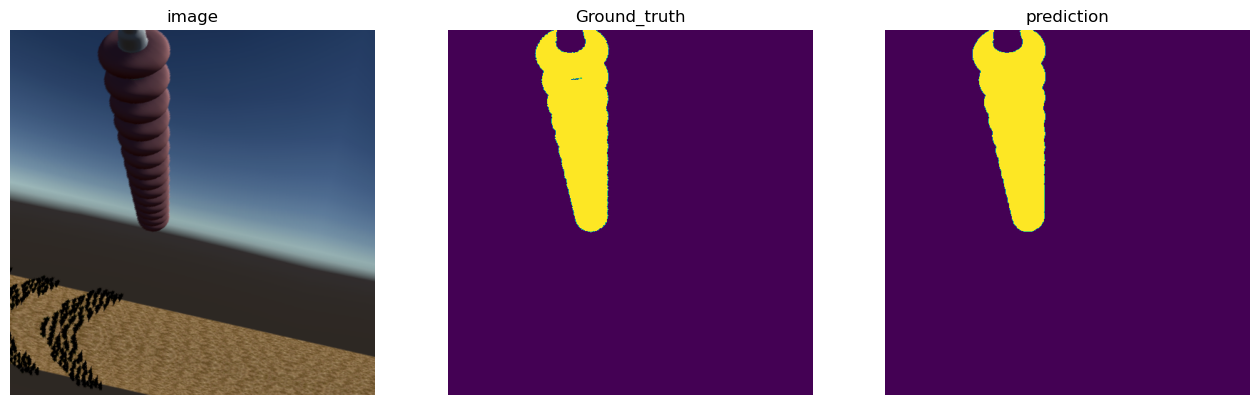

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet34_porcelain.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet34_porcelain.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_15016\2696682604.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()